In [2]:
import time
import numpy as np
import pandas as pd
from scipy.special import softmax
import matplotlib.pyplot as plt

# Synthetic Dataset Construction

In [135]:
## Initialize random data (A matrix)
m = 1000 # number of examples
d = 1000 # dim of example
k = 50 # number of output classes
# Data init
A = np.random.normal(0,1,size=(m,d)) # (# examples, dim examples)
# Param init
X = np.random.normal(0,1,size=(d,k)) # (dim examples, # classes)
E = np.random.normal(0,1,size=(m,k)) 
# Generate target classes
#b_i = np.random.randint(1, k+1, size=(m,1))
#b_i_zeroidx = b_i - 1
I_k = np.eye(k)

# This is a kinda strange way of generating data
b = np.dot(A,X) + E # (m,k)
b_i = b.argmax(axis=1) # zero indexed!
b_onehot = I_k[b_i]

# Each model will use the same initial parameters, but different than the ones used to generate the toy data.
X0 = np.random.normal(0,1,size=(d,k))
#X0 = np.zeros_like(X)

In [4]:
# for sanity
num_examples = m
example_dim = d
num_classes = k


# Full Gradient Descent

In [136]:
def grad(A, Y, X):
    Z = - A @ X
    probs = softmax(Z, axis=1)
    m = A.shape[0]
    grad_X = 1/m * (A.T @ (Y - probs))
    return grad_X

def loss(A, Y, X, Z = None):
    Z = - A @ X if Z is None else Z # avoids recalculating
    num_samples = A.shape[0]
    loss = 1/num_samples * (np.trace(A @ X @ Y.T) + np.sum(np.log(np.sum(np.exp(Z), axis=1))))
    return loss

def accuracy(X, Z = None):
    Z = - A @ X if Z is None else Z # avoids recalculating
    predictions = softmax(Z)
    predicted_labels = np.argmax(predictions, axis=1)
    actual_labels = b_i #np.argmax(b_onehot, axis=1)
    accuracy = np.mean(predicted_labels == actual_labels)
    return accuracy

# TODO: 
def gd(A, b_onehot, max_iter=1000, eta=0.1):
    X_cur = np.copy(X0)
    start_time_p = time.process_time()
    start_time_w = time.time()
    hist = []
    for i in range(max_iter):
        g = grad(A, b_onehot, X_cur)
        X_cur -= eta * g
        Z = - A @ X_cur
        # Note that calculating metrics takes CPU time
        # When compairng histories, should calculate roughly the same maetics 
        hist.append({
            'iter': i,
            'loss': loss(A, b_onehot, X_cur ,Z),
            'accuracy': accuracy(X_cur, Z),
            'grad_mag': np.linalg.norm(g, 2),
            'cpu_time': time.process_time() - start_time_p, # parallization will make this longer than exec time!
            'wall_time': time.time() - start_time_w
            })

    hist_df = pd.DataFrame(hist)
    return hist_df

In [137]:
hist_gd_df = gd(A,b_onehot, eta=1)
hist_gd_df

,iter,loss,accuracy,grad_mag,cpu_time,wall_time
0,0,71.617538,0.012,0.279470,0.015625,0.015959
1,1,69.509915,0.012,0.276836,0.078125,0.030210
2,2,67.443998,0.017,0.275578,0.156250,0.048027
3,3,65.420668,0.019,0.273840,0.250000,0.063150
4,4,63.442329,0.026,0.271114,0.359375,0.070287
...,...,...,...,...,...,...
995,995,0.000777,1.000,0.000174,93.984375,12.846715
996,996,0.000776,1.000,0.000173,94.125000,12.860723
997,997,0.000775,1.000,0.000173,94.250000,12.873235
998,998,0.000774,1.000,0.000173,94.375000,12.885235


Sources:
https://towardsdatascience.com/multiclass-logistic-regression-from-scratch-9cc0007da372

# BCGD

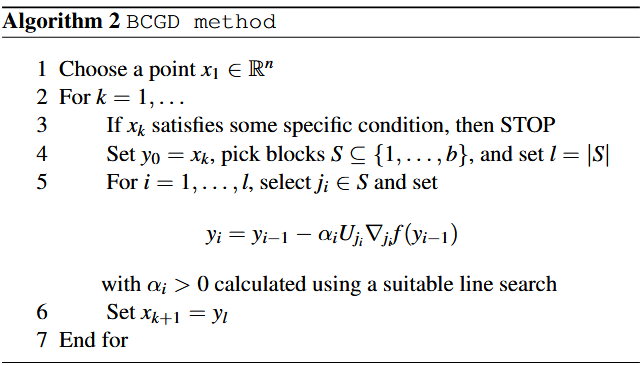

In [139]:
#TODO: calculate lipshitz constant.
L = 0.01
alpha = 1/L

In [140]:
# TODO: implement a faster version that calculates just the ith component
def gs_coord_select(X):
    """"
    Step 4 in the BCGD with GS rule.
    Picks block with maximial gradient
    we select a COORDINATE meaning we get the col of the gradient with biggest magnitude
    Using the full gradeint is more expensive that calculating just a component.
    But is needed here since we need to choose the block of max change
    """
    g = grad(A, b_onehot, X)
    i_k = np.argmax(np.linalg.norm(g, 2, axis = 0)) # select the coord (col)
    g_ik = g[:,i_k].reshape((m,1))
    return g_ik, i_k

def coord_step(X0, i_k, g_ik):
    step = - alpha * g_ik
    
    X_out = X0
    X_out[:,i_k] += step.flatten()
    return X_out


# TODO: check optimality condition for early stopping.
def BCGD(coord_select, max_iter = 100, return_hist = True):
    X_cur = np.copy(X0)
    hist = []
    start_time_p = time.process_time()
    start_time_w = time.time()
    for iter in range(max_iter):
        hist_iter = {'iter': iter}
        g_ik, i_k = coord_select(X_cur)
        X_cur = coord_step(X_cur, i_k, g_ik)
        if return_hist:
            Z = - A @ X_cur
            hist_iter = {
                'iter': iter,
                'loss': loss(A, b_onehot, X_cur, Z),
                'accuracy': accuracy(X_cur, Z),
                'i_k': i_k,
                'L2_g_ik': np.linalg.norm(g_ik,2),
                'cpu_time': time.process_time() - start_time_p, # parallization will make this longer than exec time!
                'wall_time': time.time() - start_time_w
                }
            hist.append(hist_iter)
    if return_hist:
        return pd.DataFrame(hist)
    else:
        return

def rand_coord_select(X):
    # TODO: CALCULATING THE FULL GRAD HERE IS NOT NECESSARY
    # [IMPORTANT] it will run faster if this is optimized.
    g = grad(A, b_onehot, X)
    i_k = np.random.randint(k) # select the coord (col)
    g_ik = g[:,i_k].reshape((m,1))
    return g_ik, i_k

In [141]:
hist_BCGD_GS_df = BCGD(gs_coord_select, max_iter=200)
hist_BCGD_GS_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time
0,0,71.488039,0.040,20,0.258044,0.031250,0.015947
1,1,69.170984,0.068,14,0.250762,0.140625,0.032240
2,2,67.355351,0.088,28,0.242464,0.218750,0.048135
3,3,65.449176,0.103,41,0.233972,0.328125,0.063266
4,4,63.270634,0.123,49,0.232703,0.453125,0.075843
...,...,...,...,...,...,...,...
195,195,0.000041,1.000,0,0.000048,19.156250,2.776466
196,196,0.000041,1.000,49,0.000048,19.265625,2.790283
197,197,0.000041,1.000,8,0.000048,19.375000,2.805460
198,198,0.000040,1.000,7,0.000048,19.500000,2.820559


In [142]:
hist_BCGD_rand_df = BCGD(rand_coord_select, max_iter=500)
hist_BCGD_rand_df

,iter,loss,accuracy,i_k,L2_g_ik,cpu_time,wall_time
0,0,72.378276,0.027,9,0.195967,0.046875,0.015125
1,1,70.840823,0.040,38,0.208700,0.140625,0.031304
2,2,69.431000,0.054,40,0.181959,0.203125,0.046546
3,3,67.188982,0.074,13,0.221860,0.250000,0.061168
4,4,65.340738,0.089,41,0.228017,0.328125,0.075884
...,...,...,...,...,...,...,...
495,495,0.000030,1.000,32,0.000021,49.046875,6.797094
496,496,0.000030,1.000,6,0.000008,49.171875,6.810092
497,497,0.000030,1.000,0,0.000031,49.281250,6.823363
498,498,0.000030,1.000,16,0.000045,49.343750,6.836475


In [143]:
def plot_hist(X_val, Y_val):
    # Checking optimality conditions
    # want to plot only the histories before cond. met.
    gd_sele = (hist_gd_df['grad_mag'] < 0.01).cumsum() == 0
    gs_sele = (hist_BCGD_GS_df['L2_g_ik'] < 0.01).cumsum() == 0
    rand_sele = (hist_BCGD_rand_df['L2_g_ik'] < 0.01).cumsum() < 30 # patience for random because prev. selected coords have low grad and can stop prematurely.

    fig = plt.figure()
    plt.plot(hist_gd_df[gd_sele][X_val], hist_gd_df[gd_sele][Y_val], label='GD')
    plt.plot(hist_BCGD_GS_df[gs_sele][X_val], hist_BCGD_GS_df[gs_sele][Y_val], label='GS')
    plt.plot(hist_BCGD_rand_df[rand_sele][X_val], hist_BCGD_rand_df[rand_sele][Y_val], label = 'Random')
    plt.legend()
    plt.xlabel('CPU time')
    plt.ylabel('Loss')
    plt.show()

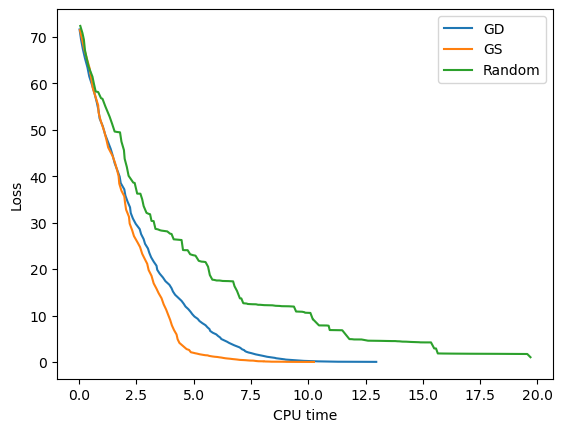

In [144]:
plot_hist('cpu_time', 'loss')

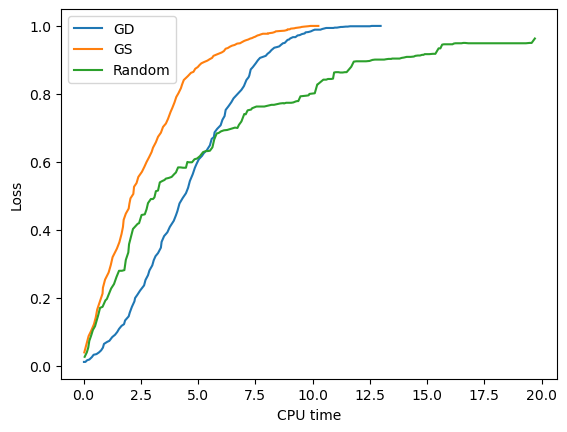

In [145]:
plot_hist('cpu_time', 'accuracy')